In [649]:
import numpy as np
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys


%matplotlib inline
warnings.simplefilter('ignore')
sns.set()

In [650]:
num_cols=[]
cols_to_del_train=[]
cols_to_del_test=[]

In [651]:
def outliers(column): 
    Q1 = column.quantile(0.25)
    Q2 = column.quantile(0.75)
    IQR = Q2 - Q1
    left = Q1 - 1.5 * IQR
    right = Q2 + 1.5 * IQR
    return (column < left).sum() + (column > right).sum(), left, right

In [652]:
def break_long_names(names):
    len_name = 12
    short_names = []
    for name in names:
        if type(name) != type('') or len(name) < len_name:
            short_names.append(name)
        else:
            short_names.append(name[:len_name] + '\n' + name[len_name:])
    else:
        return short_names

In [653]:
def plot_cat_col_vs_price(data, col, ylim, num_categories=16):
    values = data[col].value_counts().index
    if len(values) > num_categories:
        values = values[:num_categories]
    values = list(values)
    data_curr_categories = data.query(f"{col} in {values}")
    curr_categories = break_long_names(data_curr_categories[col].values)

    plt.figure()
    sns.boxplot(x=curr_categories, y=data_curr_categories['price'])
    ylim = sorted(ylim)
    plt.ylim(ylim[0], ylim[1])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('price')
    plt.grid()
    plt.show()

In [654]:
data_train=pd.read_csv('full_data_auto.csv')
data_test=pd.read_csv('test.csv')

# Обзор и первичная обработка данных

In [655]:
data_train.head()

,model,url,price,doors_amount,model_year,parsing_unixtime,год выпуска,Пробег,Кузов,Цвет,...,Госномер,Обмен,Кузов №,Запас хода,Статус,fuel_type,enginePower,engineVolume,brand,modelDate
0,Skoda Kodiaq I,https://auto.ru/cars/used/sale/skoda/kodiaq/11...,2 400 000 ₽,5.0,I 2016 – н.в.,1638365394,2019,20 000 км,внедорожник 5 дв.,белый,...,******|126,NaN,NaN,NaN,NaN,Бензин,150 л.с.,1.4 л,Skoda,2016.0
1,Skoda Rapid II,https://auto.ru/cars/used/sale/skoda/rapid/110...,1 525 000 ₽,5.0,II 2020 – н.в.,1638365396,2020,18 890 км,лифтбек,синий,...,NaN,Рассмотрю варианты,NaN,NaN,NaN,Бензин,110 л.с.,1.6 л,Skoda,2020.0
2,Skoda Superb II,https://auto.ru/cars/used/sale/skoda/superb/11...,1 450 000 ₽,5.0,II 2008 – 2013,1638365399,2012,119 730 км,универсал 5 дв.,пурпурный,...,******|197,NaN,NaN,NaN,NaN,Дизель,140 л.с.,2.0 л,Skoda,2008.0
3,Skoda Superb II,https://auto.ru/cars/used/sale/skoda/superb/11...,690 000 ₽,5.0,II 2008 – 2013,1638365402,2011,210 000 км,лифтбек,чёрный,...,******|190,NaN,NaN,NaN,NaN,Бензин,152 л.с.,1.8 л,Skoda,2008.0
4,Skoda Octavia I (A4) Рестайлинг,https://auto.ru/cars/used/sale/skoda/octavia/1...,215 000 ₽,5.0,I (A4) Рестайлинг 2000 – 2011,1638365404,2000,183 800 км,лифтбек,зелёный,...,******|198,NaN,NaN,NaN,NaN,Бензин,150 л.с.,1.8 л,Skoda,2000.0


In [656]:
data_test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [657]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40510 entries, 0 to 40509
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   model             40510 non-null  object 
 1   url               40510 non-null  object 
 2   price             40510 non-null  object 
 3   doors_amount      40500 non-null  float64
 4   model_year        40500 non-null  object 
 5   parsing_unixtime  40510 non-null  int64  
 6   год выпуска       40510 non-null  int64  
 7   Пробег            40510 non-null  object 
 8   Кузов             40510 non-null  object 
 9   Цвет              40510 non-null  object 
 10  Двигатель         40510 non-null  object 
 11  Комплектация      32694 non-null  object 
 12  Налог             39588 non-null  object 
 13  Коробка           40510 non-null  object 
 14  Привод            40510 non-null  object 
 15  Руль              40510 non-null  object 
 16  Состояние         40510 non-null  object

In [658]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [659]:
data_train = data_train.rename(columns={'fuel_type': 'fuelType', 'url': 'car_url', 
                                        'doors_amount': 'numberOfDoors', 'Кузов': 'bodyType',
                                        'Цвет': 'color', 'engineVolume': 'engineDisplacement',
                                        'Пробег': 'mileage', 'год выпуска': 'productionDate', 
                                        'Коробка': 'vehicleTransmission'})

In [660]:
#ProfileReport(data_train, title="Pandas Profiling Report for Train Dataset")

In [661]:
#ProfileReport(data_test, title="Pandas Profiling Report for Test Dataset")

In [662]:
# Создадим список с колонками, которые присутствуют и в train, и в test

cols_intersection = list(set(data_test.columns).intersection(data_train.columns))

In [663]:
# Проверим, в каких колонках типы данных различаются у train и test

cols_type_dif = []  
print("Найдены расхождения в типах данных для:")

for col in cols_intersection:
    if type(data_test[col][0]) != type(data_train[col][0]):
        print(
            f"\t- колонки {col}: для train - {type(data_train[col][0])}, для test - {type(data_test[col][0])}")
        cols_type_dif.append(col)

Найдены расхождения в типах данных для:
	- колонки mileage: для train - <class 'str'>, для test - <class 'numpy.int64'>
	- колонки numberOfDoors: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки Владение: для train - <class 'str'>, для test - <class 'float'>
	- колонки modelDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>


In [664]:
print("Пример значения для train", data_train['modelDate'].sample(1).values)
print("Пример значения для test", data_test['modelDate'].sample(1).values)

Пример значения для train [2013.]
Пример значения для test [2000]


In [665]:
data_train.dropna(subset=['modelDate'], inplace=True)

In [666]:
data_train['modelDate']=data_train['modelDate'].astype(int)

In [667]:
print("Пример значения для train", data_train['mileage'].sample(1).values)
print("Пример значения для test", data_test['mileage'].sample(1).values)

Пример значения для train ['200 000 км']
Пример значения для test [186000]


In [668]:
# Функция перевеодит формат данных "y yyy км" в количество "yyyy".

def num_of_km(row):
    if pd.notnull(row):
        list_km = row.split(' ')
        if len(list_km) == 2: 
            if list_km[1] in ['км']:
                return int(list_km[0])
        return int(list_km[0]+list_km[1])

In [669]:
data_train['mileage'] = data_train['mileage'].apply(num_of_km)

In [670]:
print("Пример значения для train", data_train['numberOfDoors'].sample(1).values)
print("Пример значения для test", data_test['numberOfDoors'].sample(1).values)

Пример значения для train [4.]
Пример значения для test [4]


In [671]:
data_train['numberOfDoors']=data_train['numberOfDoors'].astype('Int64')

Удалим колонку Владение, потому что в ней очень много пропусков и по смыслу коррелируется информация из Пробега и Дате Выпуска. 

In [672]:
cols_to_del_train.append('Владение')
cols_to_del_test.append('Владение')

In [673]:
cols_intersection

['Владельцы',
 'fuelType',
 'engineDisplacement',
 'mileage',
 'bodyType',
 'brand',
 'ПТС',
 'Привод',
 'productionDate',
 'Таможня',
 'Состояние',
 'parsing_unixtime',
 'numberOfDoors',
 'vehicleTransmission',
 'Владение',
 'modelDate',
 'Руль',
 'color',
 'car_url',
 'enginePower']

# Начнем обработку признаков с цены, а следом с общих признаков в датасетах

# Price

In [674]:
data_train['price'].sample(3)

14272      949 000 ₽
9973     2 990 000 ₽
29982      655 000 ₽
Name: price, dtype: object

In [675]:
data_train['price'] = data_train['price'].str.replace(' ', '')
data_train['price']=data_train['price'].str.replace('₽', '')
data_train = data_train[data_train['price'] != 'sold']
data_train['price']=data_train.price.astype(float).astype('Int64')

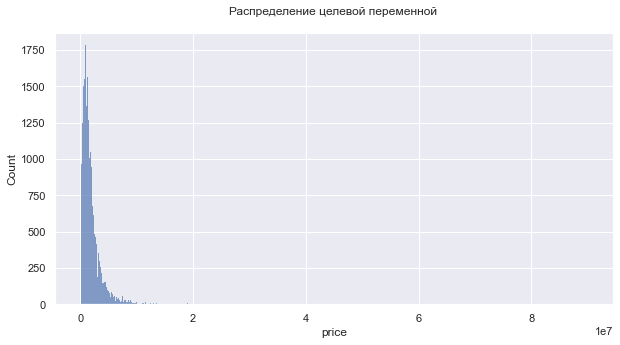

In [676]:
# Посмотрим на распределение целевой переменной
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data_train, x='price')
plt.title("Распределение целевой переменной \n")
plt.show()

In [677]:
outliers(data_train.price)

(2588, -1570500.0, 4617500.0)

In [678]:
# Посмотрим, какие машины имеют особо высокие цены
data_train[(data_train.price > 4551500.0)].groupby(['brand'])['price'].agg(['count', 'max'])

,count,max
brand,,
Audi,327,20000000
BMW,586,90000000
Honda,1,5000001
Infiniti,51,8500000
Lexus,446,23300000
Mercedes-Benz,873,80000000
Mitsubishi,2,7000000
Nissan,3,6999999
Toyota,256,14900000


Eсть очень дорогие авто, которые представлены и в тестовой выборке. Похоже, что эти бренды могут быть экстренно дорогие. Оставим как есть, можно в будещем попробовать удалить автомобилии с большой ценой, где количество таких автомобилей внутри бренда меньше 10.

<AxesSubplot:>

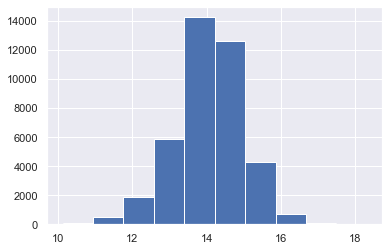

In [679]:
# Распределение цены с очень сильным правым хвостом, посмотрим на признак взяв логорифм от цены

np.log(data_train['price'] + 1).hist()

Намного лучше. Возьмем логарифм, только чуть позже

# Владельцы

In [680]:
print("Значения в train", data_train['Владельцы'].unique())
print("Значения в test", data_test['Владельцы'].unique())

Значения в train ['1 владелец' '3 или более' '2 владельца' nan]
Значения в test ['3 или более' '1\xa0владелец' '2\xa0владельца']


In [681]:
# Удаояем 1 строку с пропуском

data_train.dropna(subset=['Владельцы'], inplace=True)

In [682]:
ownersCount_dict = {'3 или более': 3,
                    '1\xa0владелец': 1,
                    '2\xa0владельца': 2,
                    '1 владелец': 1, 
                    '2 владельца': 2, 
                    '3 или более': 3}

In [683]:
data_test['Владельцы'].replace(
    to_replace=ownersCount_dict, inplace=True)

data_train['Владельцы'].replace(
    to_replace=ownersCount_dict, inplace=True)

In [684]:
print("Значения в train", data_train['Владельцы'].unique())
print("Значения в test", data_test['Владельцы'].unique())

Значения в train [1 3 2]
Значения в test [3 1 2]


In [685]:
data_train['Владельцы'][5]

3

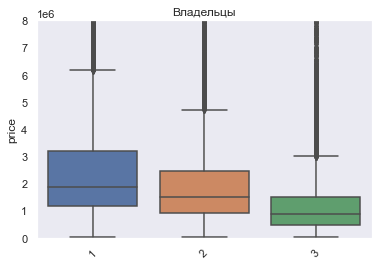

In [686]:
plot_cat_col_vs_price(data_train, 'Владельцы', [0, 8e6])

Логично, что чем меньше владельцев было у машины, тем она младще и тем дороже. Отправим признак на OneHotEncoding

# Car_url

In [687]:
print("Значения в train", data_train['car_url'].unique())
print("Значения в test", data_test['car_url'].unique())

Значения в train ['https://auto.ru/cars/used/sale/skoda/kodiaq/1106065854-e0e3e9d6/'
 'https://auto.ru/cars/used/sale/skoda/rapid/1106020729-f640cb08/'
 'https://auto.ru/cars/used/sale/skoda/superb/1105137525-90afda78/' ...
 'https://auto.ru/cars/used/sale/audi/q7/1106021243-aa185d05/'
 'https://auto.ru/cars/used/sale/audi/a6/1105732285-1e849b1b/'
 'https://auto.ru/cars/used/sale/audi/a7/1104871984-d57282d9/']
Значения в test ['https://auto.ru/cars/used/sale/skoda/octavia/1100575026-c780dc09/'
 'https://auto.ru/cars/used/sale/skoda/octavia/1100549428-595cadf2/'
 'https://auto.ru/cars/used/sale/skoda/superb/1100658222-7ac3def5/' ...
 'https://auto.ru/cars/used/sale/bmw/5er/1101364889-0c6be825/'
 'https://auto.ru/cars/used/sale/bmw/x1/1101362518-34628283/'
 'https://auto.ru/cars/used/sale/bmw/x5/1101256068-ed03accb/']


Отправляем признак в очередь на удаление

In [688]:
cols_to_del_train.append('car_url')
cols_to_del_test.append('car_url')

# Руль

In [689]:
print("Значения в train", data_train['Руль'].unique())
print("Значения в test", data_test['Руль'].unique())

Значения в train ['Левый' 'Правый']
Значения в test ['Левый' 'Правый']


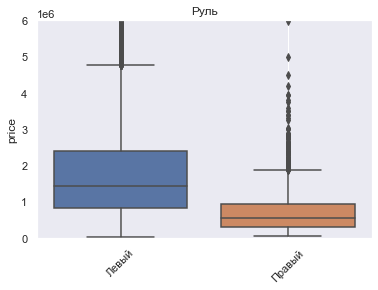

In [690]:
plot_cat_col_vs_price(data_train, 'Руль', [0, 6e6])

Отправим признак на OneHotEncoding

# FuelType

In [691]:
print("Статистика значений для train\n", data_train['fuelType'].value_counts())
print("Статистика значений для test\n", data_test['fuelType'].value_counts())

Статистика значений для train
 Бензин                                32506
Дизель                                 6424
Гибрид                                  858
Бензин, газобаллонное оборудование      421
Электро                                  84
Газ, газобаллонное оборудование           1
Гибрид, газобаллонное оборудование        1
Дизель, газобаллонное оборудование        1
Газ                                       1
Name: fuelType, dtype: int64
Статистика значений для test
 бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64


In [692]:
data_train['fuelType'] = data_train.fuelType.apply(lambda x: 'бензин' if x=='Бензин' 
                                                    else 'дизель' if x =='Дизель'
                                                    else 'гибрид' if x == 'Гибрид' 
                                                    else 'электро' if x== 'Электро'
                                                    else 'газ')

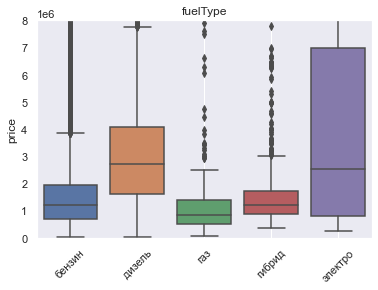

In [693]:
plot_cat_col_vs_price(data_train, 'fuelType', [0, 8e6])

Отправим признак на LabelEncoding, так как признаков уже больше, чем приемлимо для OneHotEncoding

# Parsing_unixtime

In [694]:
print("Статистика значений для train\n", data_train['parsing_unixtime'].value_counts())
print("Статистика значений для test\n", data_test['parsing_unixtime'].value_counts())

Статистика значений для train
 1638365394    1
1638679385    1
1638679363    1
1638679367    1
1638679370    1
             ..
1638475425    1
1638475429    1
1638475433    1
1638475437    1
1639131491    1
Name: parsing_unixtime, Length: 40297, dtype: int64
Статистика значений для test
 1603226273    1
1603301936    1
1603301988    1
1603301984    1
1603301980    1
             ..
1603271287    1
1603271277    1
1603271273    1
1603271270    1
1603710264    1
Name: parsing_unixtime, Length: 34686, dtype: int64


Попробуем сделать колонку с датой парсинга и, с помощью нее, колонку с курсом рубля к доллару в этот день

In [695]:
data_train['parsing_date'] = pd.to_datetime(
    data_train.parsing_unixtime, unit='s')
data_test['parsing_date'] = pd.to_datetime(
    data_test.parsing_unixtime, unit='s')

data_train['parsing_date'] = pd.to_datetime(
    data_train['parsing_date']).dt.floor('d')
data_test['parsing_date'] = pd.to_datetime(
    data_test['parsing_date']).dt.floor('d')

In [696]:
print("Значения в train", data_train['parsing_date'].unique())
print("Значения в test", data_test['parsing_date'].unique())

Значения в train ['2021-12-01T00:00:00.000000000' '2021-12-02T00:00:00.000000000'
 '2021-12-03T00:00:00.000000000' '2021-12-04T00:00:00.000000000'
 '2021-12-05T00:00:00.000000000' '2021-12-06T00:00:00.000000000'
 '2021-12-10T00:00:00.000000000']
Значения в test ['2020-10-20T00:00:00.000000000' '2020-10-19T00:00:00.000000000'
 '2020-10-21T00:00:00.000000000' '2020-10-24T00:00:00.000000000'
 '2020-10-25T00:00:00.000000000' '2020-10-26T00:00:00.000000000']


In [697]:
data_train['RUB_USD_rate'] = data_train['parsing_date'].copy().apply(lambda x: x.strftime(
    "%Y-%m-%d"))
data_test['RUB_USD_rate'] = data_test['parsing_date'].copy().apply(lambda x: x.strftime(
    "%Y-%m-%d"))

In [698]:
data_test['RUB_USD_rate'] = data_test['RUB_USD_rate'].map(
    {'2020-10-19': 77.9644, '2020-10-20': 77.9241, 
     '2020-10-21': 77.7780, '2020-10-24': 76.4667, 
     '2020-10-25': 76.4667, '2020-10-26': 76.4667})

data_train['RUB_USD_rate'] = data_train['RUB_USD_rate'].map(
    {'2021-12-01': 74.8926, '2021-12-02': 73.9746, 
     '2021-12-03': 74.0637, '2021-12-04': 73.7426,
     '2021-12-05': 73.7426, '2021-12-06': 73.7426,
     '2021-12-10': 73.5998})

Parsing_unixtime и parsing_date в модели нам не пригодятся - отправляем на удаление. 

In [699]:
cols_to_del_train.append('parsing_unixtime')
cols_to_del_test.append('parsing_unixtime')

cols_to_del_train.append('parsing_date')
cols_to_del_test.append('parsing_date')

num_cols.append('RUB_USD_rate')

# ProductionDate

In [700]:
print("Значения в train", data_train['productionDate'].unique())
print("Значения в test", data_test['productionDate'].unique())

Значения в train [2019 2020 2012 2011 2000 1998 2015 2017 2007 2013 2014 2016 2001 2008
 2010 2018 2021 2006 2005 2009 2003 1994 2002 1997 1996 1999 2004 1987
 1989 1993 1991 1990 1959 1992 1988 1995 1986 1984 1985 1982 1978 1974
 1979 1981 1968 1980 1983 1948 1939 1975 1976 1960 1971]
Значения в test [2014 2017 2012 2011 2019 2018 2010 2020 2016 2013 2006 2007 2015 2005
 2008 2009 1997 2004 2002 1987 2003 2001 1976 2000 1998 1995 1999 1993
 1939 1996 1984 1990 1991 1992 1989 1982 1985 1994 1938 1981 1988 1983
 1980 1986 1978 1970 1979 1977 1972 1975 1969 1950 1953 1949 1937 1959
 1968 1936 1904 1974 1967 1961 1960 1965 1963 1957 1952 1973 1948]


In [701]:
print("Минимальное значение в train", data_train['productionDate'].min())
print("Минимальное значение в test", data_test['productionDate'].min())

Минимальное значение в train 1939
Минимальное значение в test 1904


Не будем искать и удалять выбросы, так как в тесте тоже есть старые автомобили, цену на которые надо предсказать

<AxesSubplot:>

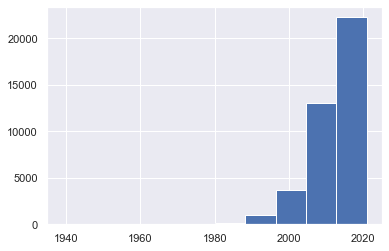

In [702]:
data_train['productionDate'].hist()

<AxesSubplot:>

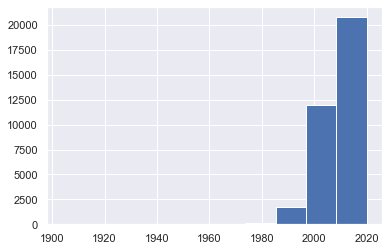

In [703]:
data_test['productionDate'].hist()

Посмотрим как будет выглядеть логарифмированный признак

<AxesSubplot:>

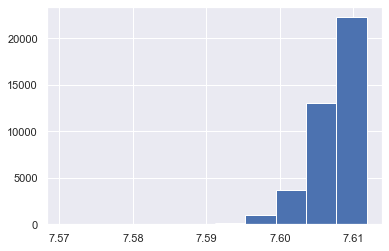

In [704]:
np.log(data_train['productionDate'] + 1).hist()

Особо не изменился.

In [705]:
cols_to_del_train.append('productionDate')
cols_to_del_test.append('productionDate')

Хочу сделать новый признак, который будет показывать сколько лет прошло от года производства машины до года парсинга. Потому что цена на определенную машину год назад (как в тестовом файле) и сейчас (как в трейне) будет отличаться, потому что машина на год постарела. Мне кажется этот признак важнее, чем просто год производства. 

In [706]:
def years_from_produse(row):
    if row['parsing_date'].year - row['productionDate'] == 0:
        return 0
    else:
        return (row['parsing_date'].year - row['productionDate'])

In [707]:
data_train['years_from_produse'] = data_train.apply(years_from_produse, axis=1)
data_test['years_from_produse'] = data_test.apply(years_from_produse, axis=1)

In [708]:
num_cols.append('years_from_produse')

# BodyType

In [709]:
print("Статистика значений для train\n", data_train['bodyType'].value_counts())
print("Статистика значений для test\n", data_test['bodyType'].value_counts())

Статистика значений для train
 внедорожник 5 дв.          18353
седан                      11842
лифтбек                     3033
хэтчбек 5 дв.               2463
универсал 5 дв.             1204
минивэн                      955
купе                         713
компактвэн                   678
хэтчбек 3 дв.                313
пикап двойная кабина         308
кабриолет                    105
внедорожник 3 дв.            101
купе-хардтоп                  89
родстер                       54
микровэн                      34
фургон                        30
седан-хардтоп                  7
седан 2 дв.                    4
пикап полуторная кабина        4
пикап одинарная кабина         3
лимузин                        3
внедорожник открытый           1
Name: bodyType, dtype: int64
Статистика значений для test
 седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн            

In [710]:
data_train['bodyType'].replace(regex={r'внедорожник.*': 'внедорожник',
                                r'седан.*': 'седан',
                                r'хэтчбек.*': 'хэтчбек',
                                r'купе.*': 'купе',  r'тарга.*': 'тарга', r'микровэн.*': 'микровэн',
                                r'пикап.*': 'пикап', r'родстер.*': 'родстер',
                                r'универсал.*': 'универсал', r'лифтбек.*': 'лифтбек',
                                r'минивэн.*': 'минивэн', r'компактвэн.*': 'компактвэн',
                                r'лимузин.*': 'лимузин', r'фургон.*': 'фургон', r'кабриолет.*': 'кабриолет'
                                },
                         inplace=True)

In [711]:
data_test['bodyType'].replace(regex={r'внедорожник.*': 'внедорожник',
                                r'седан.*': 'седан',
                                r'хэтчбек.*': 'хэтчбек',
                                r'купе.*': 'купе',  r'тарга.*': 'тарга', r'микровэн.*': 'микровэн',
                                r'пикап.*': 'пикап', r'родстер.*': 'родстер',
                                r'универсал.*': 'универсал', r'лифтбек.*': 'лифтбек',
                                r'минивэн.*': 'минивэн', r'компактвэн.*': 'компактвэн',
                                r'лимузин.*': 'лимузин', r'фургон.*': 'фургон', r'кабриолет.*': 'кабриолет'
                                },
                         inplace=True)

In [712]:
print("Статистика значений для train\n", data_train['bodyType'].value_counts())
print("Статистика значений для test\n", data_test['bodyType'].value_counts())

Статистика значений для train
 внедорожник    18455
седан          11853
лифтбек         3033
хэтчбек         2776
универсал       1204
минивэн          955
купе             802
компактвэн       678
пикап            315
кабриолет        105
родстер           54
микровэн          34
фургон            30
лимузин            3
Name: bodyType, dtype: int64
Статистика значений для test
 седан          13165
внедорожник    12346
хэтчбек         2609
лифтбек         2232
универсал       1276
минивэн          995
купе             982
компактвэн       489
пикап            290
родстер           99
фургон            97
кабриолет         90
микровэн           7
лимузин            6
тарга              2
фастбек            1
Name: bodyType, dtype: int64


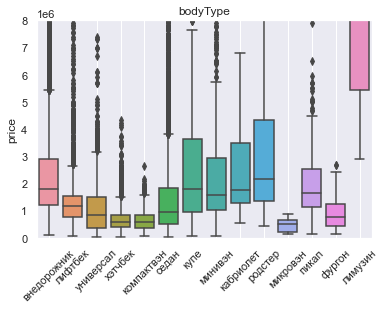

In [713]:
plot_cat_col_vs_price(data_train, 'bodyType', [0, 8e6])

Предлагаю топ 8 типов автомобилей по дороговизне и оформить как отдельный признак

In [714]:
expensive_bodyType=['внедорожник', 'купе', 'микровэн', 'кабриолет', 'родстер', 'пикап', 'лимузин']

In [715]:
data_test['expensive_bodyType']=data_test['bodyType'].apply(lambda x: 1 if x in expensive_bodyType
                                                            else 0)
data_train['expensive_bodyType']=data_train['bodyType'].apply(lambda x: 1 if x in expensive_bodyType
                                                            else 0)

А признак bodyType отправим на LabelEncoding

# Color

In [716]:
print("Статистика значений для train\n", data_train['color'].value_counts())
print("Статистика значений для test\n", data_test['color'].value_counts())

Статистика значений для train
 чёрный         11546
белый           9351
серый           5583
серебристый     3779
синий           3441
коричневый      1895
красный         1874
бежевый          737
зелёный          719
голубой          411
пурпурный        235
золотистый       233
фиолетовый       197
оранжевый        165
жёлтый           123
розовый            8
Name: color, dtype: int64
Статистика значений для test
 чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64


Сделаем новый признак, который будет показывать популярного ли цвета машина. Возмем за популярные цвета: чёрный, белый, 
серебристый, серый, синий, красный и коричневый, так как после них виден явный перепад в кол-ве автомобилей. А признак color удалить. 

In [717]:
data_train['popular_color'] = data_train['color'].apply(lambda x: 1 if x in ['чёрный', 'белый', 
                                                                 'серебристый', 'серый',
                                                                 'синий', 'красный', 'коричневый'] 
                                                    else 0)

In [718]:
data_test['popular_color'] = data_test['color'].apply(lambda x: 1 if x in ['чёрный', 'белый', 
                                                                 'серебристый', 'серый',
                                                                 'синий', 'красный', 'коричневый'] 
                                                    else 0)

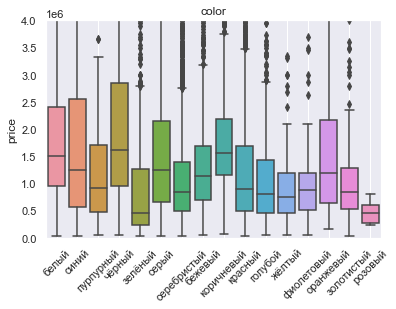

In [719]:
plot_cat_col_vs_price(data_train, 'color', [0, 4e6])

Видим, что популярные цвета обычно и дороже. 

In [720]:
cols_to_del_train.append('color')
cols_to_del_test.append('color')

# ModelDate

In [721]:
print("Значения в train", data_train['modelDate'].unique())
print("Значения в test", data_test['modelDate'].unique())

Значения в train [2016 2020 2008 2000 1996 2013 2017 2019 2015 1999 2006 2009 2007 2012
 2010 2004 1990 2001 1994 2005 1998 2011 1991 1993 1997 1983 1995 1987
 2002 2018 2014 2003 1988 1958 2021 1982 1992 1989 1985 1981 1979 1974
 1968 1975 1937 1986 1976 1977 1978 1957 1984 1971 1955 1980 1967]
Значения в test [2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949 1937 1936 1973
 1959 1958 2020 1965 1971 1904 1963 1955 1951 1960]


In [722]:
data_test['modelDate'] = data_test['modelDate'].astype(int)

<AxesSubplot:>

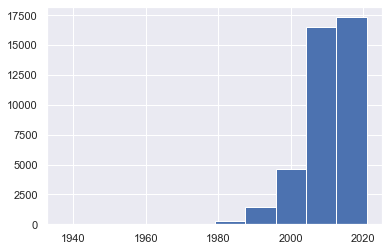

In [723]:
data_train['modelDate'].hist()

<AxesSubplot:>

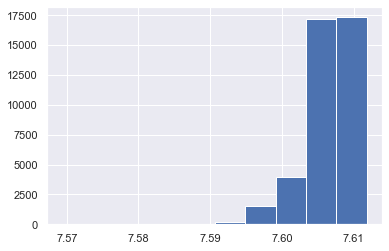

In [724]:
np.log(data_train['modelDate'] + 1).hist()

In [725]:
num_cols.append('modelDate')

# Таможня

In [726]:
print("Значения в train", data_train['Таможня'].unique())
print("Значения в test", data_test['Таможня'].unique())

Значения в train ['Растаможен']
Значения в test ['Растаможен']


Удаляем признак, так как все автомобили растаможены, но в будущем для модели нужно обращать внимание не появились ли не растаможенные автомобили. 

In [727]:
cols_to_del_train.append('Таможня')
cols_to_del_test.append('Таможня')

# Mileage

In [728]:
print("Статистика значений для train\n", data_train['mileage'].value_counts())
print("Статистика значений для test\n", data_test['mileage'].value_counts())

Статистика значений для train
 200000    372
250000    312
300000    301
180000    282
150000    264
         ... 
17727       1
286771      1
105344      1
127305      1
93345       1
Name: mileage, Length: 16998, dtype: int64
Статистика значений для test
 200000    436
150000    382
300000    381
180000    347
250000    346
         ... 
140237      1
121449      1
210311      1
121363      1
157965      1
Name: mileage, Length: 11268, dtype: int64


In [729]:
print("Максимальное значение для train", data_train['mileage'].max())
print("Максимальное значение для test", data_test['mileage'].max())

Максимальное значение для train 999999
Максимальное значение для test 1000000


In [730]:
print("Минимальное значение для train", data_train['mileage'].min())
print("Минимальное значение для test", data_test['mileage'].min())

Минимальное значение для train 1
Минимальное значение для test 1


Так как и в тестовой выборке надо предсказать стоимость автомобиля с большим пробегом, мы опять не будем искать и удалять выбросы. 

<AxesSubplot:>

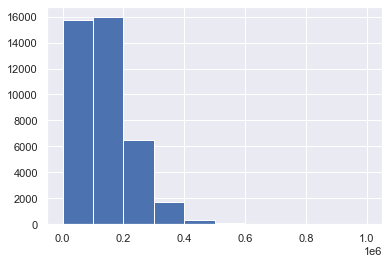

In [731]:
data_train['mileage'].hist()

<AxesSubplot:>

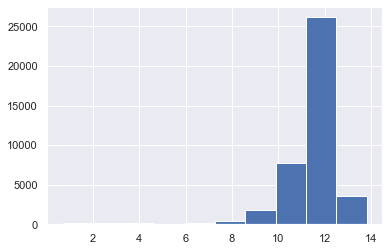

In [732]:
np.log(data_train['mileage'] + 1).hist()

Отправляем на стандартизацию

In [733]:
num_cols.append('mileage')

Еще предлагаю сделать признак который покажет сколько в год пробегала машина, потому что я думаю что есть разница проехала машина Х км за год или 5. 

In [734]:
def km_per_year(row):
    if row['mileage'] != 0:
        # обрабатываем случаи, когда машина произведена в год сбора данных, чтоб не делить на 0
        if row['productionDate'] == 2021:
            return row['mileage']
        else:
            return row['mileage']/(2021 - row['productionDate'])
    return 0  # возвращаем 0, если машина без пробега (новая)

In [735]:
data_train['km_per_year']=data_train.apply(km_per_year, axis=1)

In [736]:
data_test['km_per_year']=data_test.apply(km_per_year, axis=1)

<AxesSubplot:>

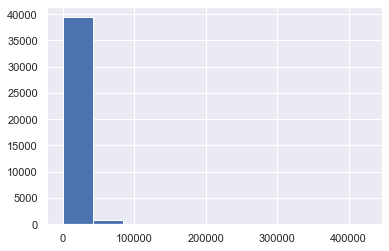

In [737]:
data_train['km_per_year'].hist()

<AxesSubplot:>

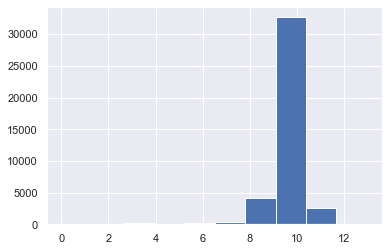

In [738]:
np.log(data_train['km_per_year'] + 1).hist()

In [739]:
num_cols.append('km_per_year')

# NumberOfDoors

In [740]:
print("Статистика значений для train\n", data_train['numberOfDoors'].value_counts())
print("Статистика значений для test\n", data_test['numberOfDoors'].value_counts())

Статистика значений для train
 5    26322
4    12582
2      975
3      418
Name: numberOfDoors, dtype: Int64
Статистика значений для test
 5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64


Автомобиль без двери - возможно это или ошибка или ретро-автомобиль. Ну в любом случае он в тестовой выборке - мы ничего не делаем. 

In [741]:
# plot_cat_col_vs_price(data_train, 'numberOfDoors', [0, 6e6])

Двухдверные машины это обычно спортиные машины, и они дороже. Отправим признак на OneHotEncoding

# EngineDisplacement

In [742]:
print("Значения в train", data_train['engineDisplacement'].unique())
print("Значения в test", data_test['engineDisplacement'].unique())

Значения в train ['1.4 л ' '1.6 л ' '2.0 л ' '1.8 л ' '1.2 л ' '3.6 л ' '1.3 л ' '1.5 л '
 '1.9 л ' '3.5 л ' '2.2 л ' '2.3 л ' '2.4 л ' '1.7 л ' '2.5 л ' '3.2 л '
 '4.4 л ' '2.9 л ' '3.0 л ' '2.8 л ' '0.7 л ' '109 л.с. ' '5.6 л '
 '3.7 л ' '4.5 л ' '2.1 л ' '5.5 л ' '4.2 л ' '6.0 л ' '4.0 л ' '4.7 л '
 '5.4 л ' '1.0 л ' '5.7 л ' '2.7 л ' '3.4 л ' '5.0 л ' '4.3 л ' '4.6 л '
 '4.8 л ' '184 л.с. ' '170 л.с. ' '6.6 л ' '3.3 л ' '3.8 л ' '150 л.с. '
 '218 л.с. ' '4.1 л ' '2.6 л ' '333 л.с. ' '408 л.с. ' '6.2 л ' '5.8 л '
 '179 л.с. ' '204 л.с. ' '136 л.с. ' '74 л.с. ' '1.1 л ' '64 л.с. '
 '67 л.с. ' '41 л.с. ' '5.9 л ' '5.2 л ' '503 л.с. ' '3.1 л ' '313 л.с. '
 '6.3 л ']
Значения в test ['1.2 LTR' '1.6 LTR' '1.8 LTR' '2.0 LTR' '1.4 LTR' '1.3 LTR' '1.0 LTR'
 '3.6 LTR' '1.5 LTR' '1.9 LTR' '2.8 LTR' '1.1 LTR' '2.5 LTR' '4.2 LTR'
 '3.0 LTR' '4.0 LTR' '5.9 LTR' '2.7 LTR' '3.1 LTR' '2.4 LTR' '5.2 LTR'
 '3.2 LTR' '4.1 LTR' '6.3 LTR' '2.3 LTR' '6.0 LTR' '2.2 LTR' '3.7 LTR'
 '2.9 LTR' '5.0 LTR' '3.3

In [743]:
data_test[data_test['engineDisplacement']==' LTR'].fuelType.unique()

array(['электро'], dtype=object)

In [744]:
# Для значений 'LTR' заменим на 0, т.к. это электрокары

engineDisplacement_dict = {' LTR':'0.0 LTR'}
                           
data_test['engineDisplacement'].replace(
    to_replace=engineDisplacement_dict, inplace=True)

In [745]:
data_test['engineDisplacement'] = data_test['engineDisplacement'].str.extract(r"(\d\.\d)", 
                                                                              expand=True).astype('float')

data_train['engineDisplacement'] = data_train['engineDisplacement'].apply(lambda x: x[:3])
data_train['engineDisplacement'] = data_train['engineDisplacement'].astype('float')

In [746]:
data_train[data_train['engineDisplacement']>10].fuelType.unique()

array(['электро'], dtype=object)

<AxesSubplot:>

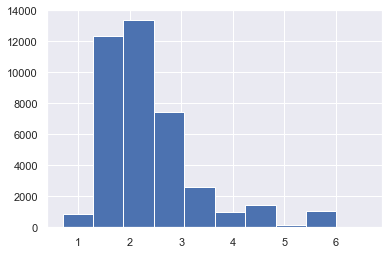

In [747]:
data_train['engineDisplacement'][data_train['engineDisplacement']<10].hist()

<AxesSubplot:>

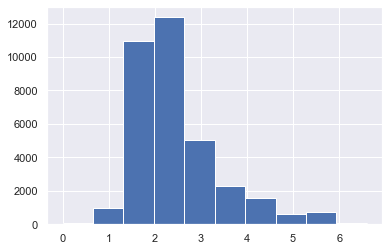

In [748]:
data_test['engineDisplacement'].hist()

In [749]:
# Прировняем значение engineDisplacement для электрокаров к одному виду

data_train['engineDisplacement'][data_train['engineDisplacement']>10]=0.0

In [750]:
num_cols.append('engineDisplacement')

# Привод

In [751]:
print("Значения в train", data_train['Привод'].unique())
print("Значения в test", data_test['Привод'].unique())

Значения в train ['передний' 'полный' 'задний']
Значения в test ['передний' 'полный' 'задний']


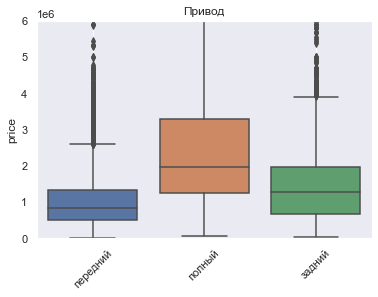

In [752]:
plot_cat_col_vs_price(data_train, 'Привод', [0, 6e6])

Отправим признак на OneHotEncoding

# VehicleTransmission

In [753]:
print("Значения в train", data_train['vehicleTransmission'].unique())
print("Значения в test", data_test['vehicleTransmission'].unique())

Значения в train ['роботизированная' 'автоматическая' 'механическая' 'вариатор']
Значения в test ['роботизированная' 'механическая' 'автоматическая' 'вариатор']


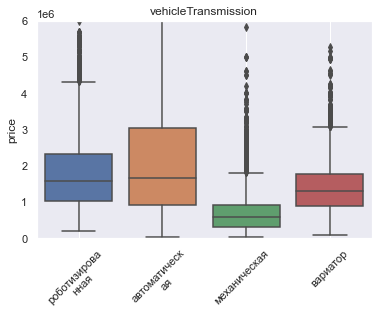

In [754]:
plot_cat_col_vs_price(data_train, 'vehicleTransmission', [0, 6e6])

Отправим признак на OneHotEncoding

# Brand

In [755]:
print("Значения в train", data_train['brand'].unique())
print("Значения в test", data_test['brand'].unique())

Значения в train ['Skoda' 'Honda' 'Volvo' 'BMW' 'Nissan' 'Infiniti' 'Mercedes-Benz'
 'Toyota' 'Lexus' 'Volkswagen' 'Mitsubishi' 'Audi']
Значения в test ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


In [756]:
print("Значения в train", data_train['brand'].unique())
print("Значения в test", data_test['brand'].unique())

Значения в train ['Skoda' 'Honda' 'Volvo' 'BMW' 'Nissan' 'Infiniti' 'Mercedes-Benz'
 'Toyota' 'Lexus' 'Volkswagen' 'Mitsubishi' 'Audi']
Значения в test ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


In [757]:
data_train['brand'] = data_train['brand'].str.lower()
data_test['brand'] = data_test['brand'].str.lower()

In [758]:
data_train['brand'][data_train['brand']=='mercedes-benz']='mercedes'

In [759]:
print("Статистика значений для train\n", data_train['brand'].value_counts())
print("Статистика значений для test\n", data_test['brand'].value_counts())

Статистика значений для train
 honda         3840
skoda         3716
bmw           3662
nissan        3662
mercedes      3662
toyota        3662
mitsubishi    3662
volkswagen    3660
audi          3660
lexus         3163
volvo         2442
infiniti      1506
Name: brand, dtype: int64
Статистика значений для test
 bmw           4473
volkswagen    4404
nissan        4393
mercedes      4180
toyota        3913
audi          3421
mitsubishi    2843
skoda         2741
volvo         1463
honda         1150
infiniti       871
lexus          834
Name: brand, dtype: int64


Какие-то популярные топ брендов не выделяется одинаковый и в train и в test. Отправим признак на кодирование.  

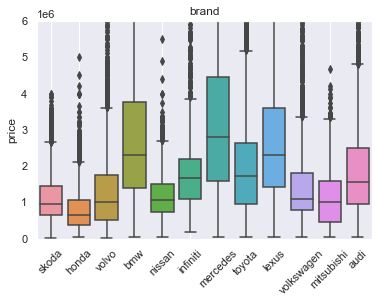

In [760]:
plot_cat_col_vs_price(data_train, 'brand', [0, 6e6])

Предлагаю сделать новый признак о дороговизне машин. 

In [761]:
expensive_brand=['audi', 'bmw', 'infiniti', 'mercedes', 'toyota', 'lexus']

In [762]:
data_test['expensive_brand']=data_test['brand'].apply(lambda x: 1 if x in expensive_brand
                                                            else 0)
data_train['expensive_brand']=data_train['brand'].apply(lambda x: 1 if x in expensive_brand
                                                            else 0)

А признак brand отправим признак на LabelEncoding

# Состояние

In [763]:
print("Значения в train", data_train['Состояние'].unique())
print("Значения в test", data_test['Состояние'].unique())

Значения в train ['Не требует ремонта']
Значения в test ['Не требует ремонта']


Удаляю признак, так как он имеет только 1 значение, но в будущем нужно обращать внимание на этот признак, возможно появятся еще значения  

In [764]:
cols_to_del_train.append('Состояние')
cols_to_del_test.append('Состояние')

# EnginePower

In [765]:
print("Пример значения для train", data_train['enginePower'].sample(1).values)
print("Пример значения для test", data_test['enginePower'].sample(1).values)

Пример значения для train [' 125 л.с. ']
Пример значения для test ['280 N12']


In [766]:
# Преобразовываем значения столбца, избавляемся от постфиков л.с. и N12
data_train['enginePower'] = data_train['enginePower'].apply(
    lambda x: int(x.split(" ")[1]))
data_test['enginePower'] = data_test['enginePower'].apply(
    lambda x: int(x.split(" ")[0]))

<AxesSubplot:>

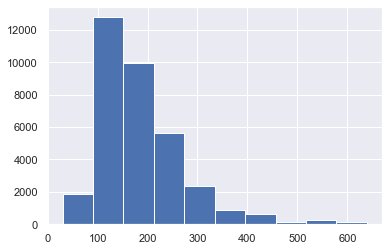

In [767]:
data_test['enginePower'].hist()

<AxesSubplot:>

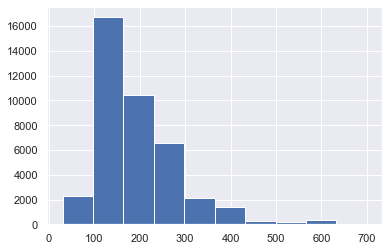

In [768]:
data_train['enginePower'].hist()

Не хороший хвост у графика, посмотрим как будет выглядеть логарифмированный признак

<AxesSubplot:>

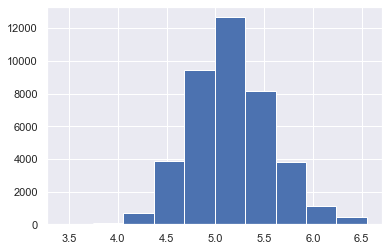

In [769]:
np.log(data_train['enginePower'] + 1).hist()

<AxesSubplot:>

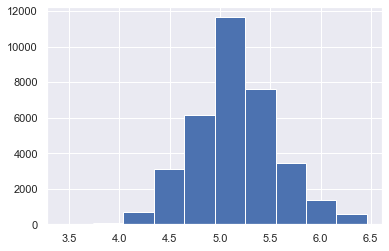

In [770]:
np.log(data_test['enginePower'] + 1).hist()

Так намного лучше! Отправим на стандартизацию

In [771]:
num_cols.append('enginePower')

# ПТС

In [772]:
print("Значения в train", data_train['ПТС'].unique())
print("Значения в test", data_test['ПТС'].unique())

Значения в train ['Оригинал' 'Дубликат']
Значения в test ['Оригинал' 'Дубликат' nan]


In [773]:
print("Заполнено значений в train", data_train['ПТС'].isna().value_counts())
print("Заполнено значений в test", data_test['ПТС'].isna().value_counts())

Заполнено значений в train False    40297
Name: ПТС, dtype: int64
Заполнено значений в test False    34685
True         1
Name: ПТС, dtype: int64


In [774]:
# Пропуск только 1, но он в test, поэтому заменим его на категорию. Выберем 'Дубликат'.

data_test['ПТС']=data_test['ПТС'].fillna('Дубликат')

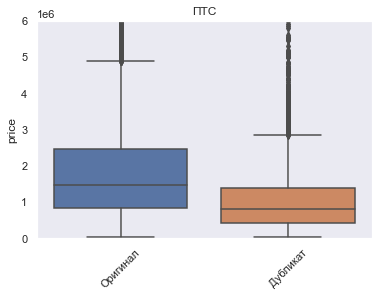

In [775]:
plot_cat_col_vs_price(data_train, 'ПТС', [0, 6e6])

Отправим признак на OneHotEncoding

# Обзор признаков, которых нет или в test или в train

In [776]:
# Список колонок, которых нет в test
dif_list_2 = list(set(data_train.columns).difference(data_test.columns))
print("Список колонок, которых нет в test, но есть в train:", dif_list_2)

Список колонок, которых нет в test, но есть в train: ['Гарантия', 'Налог', 'Кузов №', 'Обмен', 'Двигатель', 'price', 'Госномер', 'model_year', 'VIN', 'Комплектация', 'Запас хода', 'model', 'Статус']


In [777]:
# Посмотрим на данные в этих колонках
data_train[dif_list_2].sample(3)

,Гарантия,Налог,Кузов №,Обмен,Двигатель,price,Госномер,model_year,VIN,Комплектация,Запас хода,model,Статус
13297,NaN,4 095 ₽ / год,NaN,Рассмотрю варианты,"['1.6 л ', ' 117 л.с. ', ' ,Бензин']",1520000,NaN,I Рестайлинг 2014 – 2019,SJN**************,LE+ Perso Black,NaN,Nissan Juke I Рестайлинг,NaN
23662,До ноября 2023,NaN,NaN,Рассмотрю варианты,"['2.4 л ', ' 150 л.с. ', ' ,Дизель']",2250000,NaN,VIII 2015 – 2020,MR0**************,30 опций,NaN,Toyota Hilux VIII,NaN
18865,NaN,10 450 ₽ / год,NaN,NaN,"['2.1 л ', ' 190 л.с. ', ' ,Дизель']",7450000,******|799,II 2014 – н.в.,W1V**************,V250 d экстра длинный,NaN,Mercedes-Benz V-Класс XL 250 d экстра длинный II,NaN


In [778]:
print("Значения в train", data_train['Запас хода'].unique())

Значения в train [nan '170 км' '175 км' '64 км' '31 км' '200 км' '203 км' '260 км' '3 км'
 '37 км' '130 км' '270 км' '385 км' '199 км' '250 км' '106 км' '770 км'
 '30 км' '445 км' '417 км' '23 км' '2 км' '50 км' '201 км' '54 км'
 '160 км' '150 км' '436 км' '370 км' '343 км' '347 км' '336 км' '446 км']


In [779]:
print("Значения в train", data_train['Налог'].unique())

Значения в train ['2 175 ₽ / год' '2 750 ₽ / год' '4 900 ₽ / год' ... '25 400 ₽ / год'
 '50 000 ₽ / год' '25 296 ₽ / год']


In [780]:
print("Значения в train", data_train['Гарантия'].unique())

Значения в train ['До мая 2022' nan 'До марта 2023' 'До августа 2022' 'До июня 2023'
 'До октября 2022' 'До октября 2024' 'До мая 2025' 'До ноября 2023'
 'До сентября 2022' 'До сентября 2024' 'До декабря 2022' 'До октября 2023'
 'До июля 2022' 'До декабря 2023' 'До сентября 2023' 'До июня 2025'
 'До июня 2022' 'До марта 2024' 'До апреля 2023' 'До июня 2024'
 'До мая 2024' 'До ноября 2024' 'До ноября 2022' 'До июля 2024'
 'До января 2022' 'До апреля 2024' 'До декабря 2021' 'До апреля 2025'
 'До января 2024' 'До августа 2023' 'До февраля 2024' 'До июля 2023'
 'До марта 2022' 'До мая 2023' 'До декабря 2024' 'До февраля 2023'
 'До апреля 2022' 'До июля 2026' 'До декабря 2025' 'До августа 2024'
 'До января 2023' 'До ноября 2021' 'До августа 2025' 'До января 2025'
 'До сентября 2021' 'До декабря 2030' 'До октября 2025' 'До февраля 2022'
 'До ноября 2025' 'До октября 2021' 'До ноября 2026' 'До сентября 2025'
 'До ноября 2030' 'До мая 2026' 'До сентября 2026' 'До августа 2026'
 'До марта 2025'

In [781]:
print("Значения в train", data_train['Кузов №'].unique())

Значения в train [nan 'GP71***********' 'GE6-1***********' 'RA6-1***********'
 'GD11***********' 'RP1-1***********' 'OTSYT***********' 'RN11***********'
 'AK12***********' 'E12***********' 'ZE0-***********' 'BZ11***********'
 'A32***********' 'M910A-0***********' 'JZS141-0***********'
 'JZS1450***********' 'CU4W0***********' 'EA1A0***********'
 '50***********' 'RD11***********' 'GP23***********' 'RG2-1***********'
 'GB31***********' 'HH5-2***********' 'MA41***********' 'JH2-1***********'
 'JF22***********' 'ES11***********' 'RF21***********' 'RC1-1***********'
 'GP7-1***********' 'RC2-1***********' 'RU4-1***********'
 'JG1-***********' 'RB13***********' 'RC4-1***********' 'RC1-***********'
 'EK2-1***********' 'GP11***********' 'RA2-1***********' 'RK11***********'
 'RP3-1***********' 'JF3-1***********' 'RA7-1***********'
 'GP51***********' 'JH1-2***********' 'EK2-3***********'
 'RU3-1***********' 'RA61***********' 'UA2-1***********'
 'TA2-1***********' 'RF31***********' 'GB3-1**********

In [782]:
print("Значения в train", data_train['Обмен'].unique())

Значения в train [nan 'Рассмотрю варианты']


In [783]:
print("Значения в train", data_train['Статус'].unique())

Значения в train [nan 'На заказ']


Жаль таких признаков нет в test. Удалю Госномер, model_year, Кузов №, VIN, Обмен, Статус. Остальные может быть понадобятся для генерации признаков

In [784]:
cols_to_del_train.append('Госномер')
cols_to_del_train.append('model_year')
cols_to_del_train.append('Кузов №')
cols_to_del_train.append('VIN')
cols_to_del_train.append('Обмен')
cols_to_del_train.append('Статус')

In [785]:
# Список колонок, которых нет в train
dif_list = list(set(data_test.columns).difference(data_train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list)
    
# Посмотрим на данные в этих колонках
data_test[dif_list].sample(3)

Список колонок, которых нет в train, но есть в test: ['vendor', 'equipment_dict', 'name', 'priceCurrency', 'model_name', 'complectation_dict', 'image', 'description', 'super_gen', 'model_info', 'vehicleConfiguration', 'sell_id']


,vendor,equipment_dict,name,priceCurrency,model_name,complectation_dict,image,description,super_gen,model_info,vehicleConfiguration,sell_id
11748,JAPANESE,NaN,3.0d MT (158 л.с.) 4WD,RUB,PATROL,NaN,https://avatars.mds.yandex.net/get-autoru-vos/...,Год выпуска: 2000. Пробег: 219 000 км. Кузов: ...,"{""id"":""4841827"",""displacement"":2953,""engine_ty...","{""code"":""PATROL"",""name"":""Patrol"",""ru_name"":""Па...",ALLROAD_5_DOORS MECHANICAL 3.0,1098239466
12898,JAPANESE,"{""steel-wheels"":true,""ptf"":true,""airbag-driver...",2.4 MT (124 л.с.) 4WD,RUB,TERRANO,NaN,https://avatars.mds.yandex.net/get-autoru-vos/...,"Авто в хорошем состоянии, пробег 20 000 после ...","{""id"":""20197871"",""displacement"":2389,""engine_t...","{""code"":""TERRANO"",""name"":""Terrano"",""ru_name"":""...",ALLROAD_3_DOORS MECHANICAL 2.4,1072300844
26928,JAPANESE,"{""electro-window-back"":true,""asr"":true,""ptf"":t...",2.5d AT (178 л.с.) 4WD,RUB,PAJERO_SPORT,NaN,https://avatars.mds.yandex.net/get-autoru-vos/...,КЛЮЧАВТО | автомобили с пробегом — направление...,"{""id"":""20156568"",""displacement"":2477,""engine_t...","{""code"":""PAJERO_SPORT"",""name"":""Pajero Sport"",""...",ALLROAD_5_DOORS AUTOMATIC 2.5,1101238761


Пока что явно можно удалить image. Sell_id нам нужен. С остальными попробую поработать

In [786]:
cols_to_del_test.append('image')

# Equipment_dict

In [787]:
print("Пример значения для test", data_test['equipment_dict'].sample(1).values)

Пример значения для test ['{"cruise-control":true,"asr":true,"tinted-glass":true,"esp":true,"adaptive-light":true,"usb":true,"sport-seats":true,"multi-wheel":true,"audiosystem-tv":true,"heated-wash-system":true,"airbag-passenger":true,"front-centre-armrest":true,"navigation":true,"apple-carplay":true,"front-seat-support":true,"decorative-interior-lighting":true,"bas":true,"20-inch-wheels":true,"lock":true,"door-sill-panel":true,"servo":true,"drl":true,"electro-mirrors":true,"steering-wheel-gear-shift-paddles":true,"electro-window-back":true,"mirrors-heat":true,"volume-sensor":true,"park-assist-f":true,"leather":true,"wheel-heat":true,"led-lights":true,"driver-seat-memory":true,"sport-pedals":true,"music-super":true,"park-assist-r":true,"knee-airbag":true,"glonass":true,"start-stop-function":true,"airbag-driver":true,"aux":true,"isofix":true,"projection-display":true,"electro-window-front":true,"drive-mode-sys":true,"light-sensor":true,"hcc":true,"automatic-lighting-control":true,"airba

К сожалению, ничего не совпадает с train. Удаляем.

In [788]:
cols_to_del_test.append('equipment_dict')

# Name

In [789]:
print("Пример значения для test", data_test['name'].sample(1).values)

Пример значения для test ['523i 2.5 AT (177 л.с.)']


Name - дублирует информацию из колонок engineDisplacement, enginePower. Удаляю

In [790]:
cols_to_del_test.append('name')

# Complectation_dict

In [791]:
print("Пример значения для test", data_test['complectation_dict'].sample(1).values)

Пример значения для test [nan]


Тоже ничего полезного. Удаляю

In [792]:
cols_to_del_test.append('complectation_dict')

# Model_info, model_name и model

Попробуем достать data_train['model'] название модели в соответствии с data_test['model_name'] и на базе этой информации создать новый признак о популярности модели.

In [793]:
print("Пример значения для test", data_test['model_info'].sample(1).values)

Пример значения для test ['{"code":"COROLLA","name":"Corolla","ru_name":"Королла","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}']


In [794]:
data_test['model_name'].value_counts()

OCTAVIA     1418
5ER         1026
LANCER       855
E_KLASSE     809
PASSAT       782
            ... 
MR_S           1
VELLFIRE       1
VERSO_S        1
Z3M            1
PLATZ          1
Name: model_name, Length: 544, dtype: int64

In [795]:
print("Значения в train", data_train['model'].unique())

Значения в train ['Skoda Kodiaq I' 'Skoda Rapid II' 'Skoda Superb II' ...
 'Audi A4 16V III (B7)' 'Audi 100 II (C2)'
 'Audi A8 Long I (D2) Рестайлинг']


In [796]:
data_train['model'] = data_train['model'].apply(
    lambda x: x.split(" ")[1])

In [797]:
data_train['model'].value_counts()

Octavia      1444
Outlander    1152
Polo         1114
RX           1059
Qashqai       890
             ... 
Eterna          1
3000            1
Z               1
Sigma           1
GT86            1
Name: model, Length: 431, dtype: int64

In [798]:
data_train['model'] = data_train['model'].str.lower()
data_test['model_name'] = data_test['model_name'].str.lower()

model_df_train = pd.Series(data_train['model'])
model_df_test = pd.Series(data_test['model_name'])

model_data=pd.concat([model_df_train, model_df_test])

In [799]:
# Определяем популярность по среднему значению частоты встречаний значения в датасетах
model_df = pd.DataFrame(model_data.value_counts())
mean_model = model_data.value_counts().values.mean()

# Добавляем признак во временный датафрейм
model_df['modelPopular'] = model_df[0].apply(
    lambda x: 1 if x >= mean_model else 0)

# Создаем словарь популярности модели
dict_model = model_df.to_dict()['modelPopular']
dict_model_is_popular = {k: v for k, v in dict_model.items() if v == 1}

#Преоюразуем словарь в список
list_model_is_popular=list(dict_model_is_popular)

In [800]:
data_train['modelPopular'] = data_train['model'].apply(lambda x: 1 if x in list_model_is_popular
                                                    else 0)
data_test['modelPopular'] = data_test['model_name'].apply(lambda x: 1 if x in list_model_is_popular
                                                    else 0)

In [801]:
data_train['modelPopular'].value_counts()

1    35399
0     4898
Name: modelPopular, dtype: int64

In [802]:
data_test['modelPopular'].value_counts()

1    29228
0     5458
Name: modelPopular, dtype: int64

Отлично, даже отношение примерно одинаковое. Оставляем признак и удаляем столбцы со значениями модели

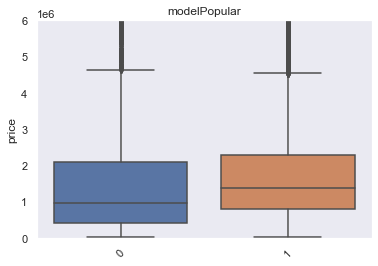

In [803]:
plot_cat_col_vs_price(data_train, 'modelPopular', [0, 6e6])

In [804]:
cols_to_del_test.append('model_name')
cols_to_del_test.append('model_info')
cols_to_del_train.append('model')

# Vendor

In [805]:
print("Значения в test", data_test['vendor'].unique())

Значения в test ['EUROPEAN' 'JAPANESE']


Попробуем создать словарь из vendor и brand и по нему создать признак vendor в train.

In [806]:
# Создаем словарь из вендоров по брендам
vendor_dict = data_test.groupby(['vendor'])['brand'].apply(
    lambda grp: list(grp.value_counts().index)).to_dict()
vendor_dict

{'EUROPEAN': ['bmw', 'volkswagen', 'mercedes', 'audi', 'skoda', 'volvo'],
 'JAPANESE': ['nissan', 'toyota', 'mitsubishi', 'honda', 'infiniti', 'lexus']}

In [807]:
# Создадим новый словарь для мапинга
new_map = {str(x): str(k) for k, v in vendor_dict.items() for x in v}

In [808]:
# Создаем признак vendor в train
data_train['vendor'] = data_train.brand.copy()
data_train['vendor'] = data_train['vendor'].map(new_map)

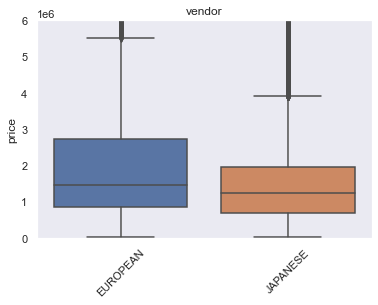

In [809]:
plot_cat_col_vs_price(data_train, 'vendor', [0, 6e6])

Отправим признак на OneHotEncoding

# Description

In [810]:
print("Пример значения для test", data_test['description'].sample(1).values)

Пример значения для test ['Состояние нового авто.Предыдущих хозяев знал лично, с автомобиля пыль сдували, кузов в родной краске.Обклеена плёнкой, Камера заднего вида, большой экран, охранный комплекс, два комплекта резины на дисках.']


Я удалю этот признак, но как идея на будущее - покапаться в описании и возможно можно достать новые признаки из него. 

In [811]:
cols_to_del_test.append('description')

# VehicleConfiguration

In [812]:
print("Пример значения для test", data_test['vehicleConfiguration'].sample(1).values)

Пример значения для test ['ALLROAD_5_DOORS AUTOMATIC 5.5']


vehicleConfiguration - дублирует информацию из колонок vehicleTransmission, engineDisplacement, bodyType. Удаляю

In [813]:
cols_to_del_test.append('vehicleConfiguration')

# Super_gen

In [814]:
print("Пример значения для test", data_test['super_gen'].sample(1).values)

Пример значения для test ['{"id":"7277667","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"VARIATOR","power":117,"power_kvt":86,"human_name":"1.6 CVT (117 л.с.)","acceleration":11.5,"clearance_min":180,"fuel_rate":6.3}']


In [815]:
import ast

data_test['super_gen'] = data_test['super_gen'].apply(
    lambda x: ast.literal_eval(x))

In [816]:
data_test['super_gen'][5]['fuel_rate']

7.7

In [817]:
data_test['fuel_rate']=data_test['super_gen'].copy()

for i in range(0, len(data_test)):
    data_test['fuel_rate'][i] = data_test['super_gen'][i].get('fuel_rate')

<AxesSubplot:>

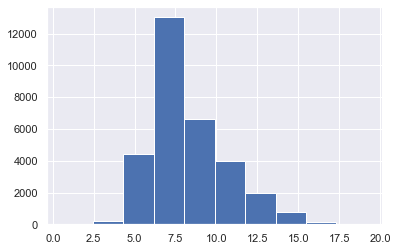

In [818]:
data_test['fuel_rate'].hist()

Похоже, что таких данные нет в train. Как идея на будущее - поискать дополнительные данные по модели автомобиля. Пока что удаляем. признак. 

In [819]:
cols_to_del_test.append('super_gen')
cols_to_del_test.append('fuel_rate')

# PriceCurrency

In [820]:
print("Значения в test", data_test['priceCurrency'].unique())

Значения в test ['RUB']


Все цены в рублях. Удалим признак

In [821]:
cols_to_del_test.append('priceCurrency')

# Двигатель, Запас хода	, Комплектация, Налог и Гарантия

Удаляем э ти признаки, так как нет полезности в них в итоге на данный момент. Идея на будущее - поискать эти данные в описании

In [822]:
cols_to_del_train.append('Двигатель')
cols_to_del_train.append('Запас хода')
cols_to_del_train.append('Комплектация')
cols_to_del_train.append('Налог')
cols_to_del_train.append('Гарантия')

# Удаляем ненужные колонки

In [823]:
data_train.drop(cols_to_del_train, axis=1, inplace=True)
data_test.drop(cols_to_del_test, axis=1, inplace=True)

# Обработка пропусков

In [824]:
data_train.isnull().sum()

price                  0
numberOfDoors          0
mileage                0
bodyType               0
vehicleTransmission    0
Привод                 0
Руль                   0
Владельцы              0
ПТС                    0
fuelType               0
enginePower            0
engineDisplacement     0
brand                  0
modelDate              0
RUB_USD_rate           0
years_from_produse     0
expensive_bodyType     0
popular_color          0
km_per_year            0
expensive_brand        0
modelPopular           0
vendor                 0
dtype: int64

Пропусков немного, можем себе позволить удалить строки с пропусками

In [825]:
data_train.dropna(subset=['numberOfDoors'], inplace=True)
data_train.dropna(subset=['modelDate'], inplace=True)

# Обработка оставшихся выбросов

In [826]:
num_cols

['RUB_USD_rate',
 'years_from_produse',
 'modelDate',
 'mileage',
 'km_per_year',
 'engineDisplacement',
 'enginePower']

In [827]:
outliers(data_train['price'])

(2588, -1570500.0, 4617500.0)

In [828]:
print(data_train.loc[data_train['price'] > 4551500.0].modelDate.unique())

[2019 2018 2017 2020 2015 2014 1958 2008 2013 2016 2021 2012 1999 1937
 2004 2011 1957 2010 2003 1990 1998 1955 2007 1978]


Все так же, и в основном это или новые или очень старые (раритетные) машины. Что похоже на правду, поэтому не удаляем выбросы. Это относится соответственно и к price_usd

In [829]:
outliers(data_train['RUB_USD_rate'])

(5119, 73.3946, 74.3226)

Выбросы тут не будут удаляться, так как этот признак добавлен руками и проверен на точность

In [830]:
outliers(data_train['modelDate'])

(1267, 1995.0, 2027.0)

In [831]:
print(data_test.loc[data_test['modelDate'] < 1995.0].modelDate.unique())

[1994 1976 1969 1989 1934 1986 1990 1991 1987 1980 1982 1938 1988 1983
 1978 1979 1984 1992 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949
 1937 1936 1973 1959 1958 1965 1971 1904 1963 1955 1951 1960]


Не буду удалять выбросы, потому что надо предстазать и для таких же 

In [832]:
outliers(data_train['years_from_produse'])

(870, -9.5, 26.5)

То же самое, что с years_from_produse и modelDate, потому что эти выбросы прямо вытекают из предыдущих

In [833]:
outliers(data_train['mileage'])

(804, -110472.5, 370283.5)

In [834]:
print(data_train.loc[data_train['mileage'] > 371500.0].modelDate.unique())

[2000 2013 2008 2004 1993 1987 1991 1995 2002 1997 1999 2007 2003 2005
 2011 2001 1994 1998 2006 1996 1988 1989 1985 1992 1983 1990 1974 1982
 2012 1986 1981 1977 2014 2010 1984 2009 2019 1975 1978 1976]


Правктически все очень старые машины, для которых пробег большой - оставляем. 

In [835]:
outliers(data_train['engineDisplacement'])

(1117, -0.49999999999999956, 5.1)

In [836]:
print(data_train.loc[data_train['engineDisplacement'] > 4.85].brand.unique())

['nissan' 'infiniti' 'mercedes' 'toyota' 'lexus' 'bmw' 'audi']


In [837]:
data_train['engineDisplacement'].max()

6.6

In [838]:
outliers(data_train['enginePower'])

(1378, -17.0, 391.0)

In [839]:
print(data_train.loc[data_train['enginePower'] > 390.0].brand.unique())

['bmw' 'nissan' 'infiniti' 'mercedes' 'lexus' 'volvo' 'toyota' 'audi']


Одни и те же бренды в выбросах. А так как объем двигателя и его мощность связаны, риску предположить что эти выбросы обоснованы. Оставляем

In [840]:
outliers(data_train['km_per_year'])

(1784, -2575.4166666666642, 35323.027777777774)

In [841]:
print(data_train.loc[data_train['km_per_year'] > 35535.71428571429].modelDate.unique())

[2017 2020 2012 2015 2016 2013 2019 2010 2008 2018 2014 2005 2011 1995
 2009 1989 2003 2006 2007 1998]


Большая часть - машины старые, а молодые поэтому и продаются, что пробег сделали большой. Оставляем

# OneHotEncoder и LabelEncoder

Оставим данные без инкодинга и стандартизации для решающих деревьев. 

In [842]:
data_train_for_cat=data_train.copy()
data_test_for_cat=data_test.copy()

In [843]:
data_train = pd.get_dummies(data_train, columns=['Владельцы'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['Владельцы'], drop_first=True)

In [844]:
data_train = pd.get_dummies(data_train, columns=['Руль'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['Руль'], drop_first=True)

In [845]:
data_train = pd.get_dummies(data_train, columns=['numberOfDoors'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['numberOfDoors'], drop_first=True)

In [846]:
# Удаляем колонку, которая осталась из-за автомобиля без дверей, чтобы колонки были одинаковые в трейне и тесте 

data_test = data_test.drop('numberOfDoors_2',axis=1)

In [847]:
data_train = pd.get_dummies(data_train, columns=['Привод'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['Привод'], drop_first=True)

In [848]:
data_train = pd.get_dummies(data_train, columns=['vehicleTransmission'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['vehicleTransmission'], drop_first=True)

In [849]:
data_train = pd.get_dummies(data_train, columns=['ПТС'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['ПТС'], drop_first=True)

In [850]:
data_train = pd.get_dummies(data_train, columns=['vendor'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['vendor'], drop_first=True)

Сделаем ручной LabelEncoding, так как тут вариантов признака больше чем приемлимо для OneHotEncoding

In [851]:
fuelType_dict = {'бензин':'5',
                 'дизель':'4',
                 'гибрид':'3',
                 'электро':'2',
                 'газ':'1'}    

In [852]:
data_test['fuelType'].replace(
    to_replace=fuelType_dict, inplace=True)
data_train['fuelType'].replace(
    to_replace=fuelType_dict, inplace=True)

In [853]:
data_test['fuelType']=data_test['fuelType'].astype(float).astype(int)
data_train['fuelType']=data_train['fuelType'].astype(float).astype(int)

In [854]:
bodyType_dict = {'фастбек':'1',
                 'тарга':'2',
                 'внедорожник открытый':'3',
                 'пикап полуторная кабина':'4',
                 'пикап одинарная кабина':'5',
                 'лимузин':'6',
                 'седан 2 дв.':'7',
                 'микровэн':'8',
                 'седан-хардтоп':'9',
                 'кабриолет':'10',
                 'фургон':'11',
                 'родстер':'12',
                 'внедорожник 3 дв.':'13',
                 'купе-хардтоп':'14',
                 'пикап двойная кабина':'15',
                 'хэтчбек 3 дв.':'16',
                 'компактвэн':'17',
                 'купе':'18',
                 'минивэн':'19',
                 'универсал 5 дв.':'20',
                 'хэтчбек 5 дв.':'21',
                 'лифтбек':'22',
                 'внедорожник 5 дв.':'23',
                 'седан':'24',
                 'внедорожник':'25', 
                 'хэтчбек':'26', 
                 'универсал':'27', 
                 'пикап':'28'}      

In [855]:
data_test['bodyType'].replace(
    to_replace=bodyType_dict, inplace=True)
data_train['bodyType'].replace(
    to_replace=bodyType_dict, inplace=True)

In [856]:
data_test['bodyType']=data_test['bodyType'].astype(float).astype(int)
data_train['bodyType']=data_train['bodyType'].astype(float).astype(int)

In [857]:
brand_dict = {'lexus':'1',
              'infiniti':'2',
              'honda':'3',
              'volvo':'4',
              'skoda':'5',
              'mitsubishi':'6',
              'audi':'7',
              'toyota':'8',
              'mercedes':'9',
              'nissan':'10',
              'volkswagen':'11',
              'bmw':'12'}    

In [858]:
data_test['brand'].replace(
    to_replace=brand_dict, inplace=True)
data_train['brand'].replace(
    to_replace=brand_dict, inplace=True)

In [859]:
data_test['brand']=data_test['brand'].astype(float).astype(int)
data_train['brand']=data_train['brand'].astype(float).astype(int)

# Проверка на то, что все колонки и их тип данных совпадают

In [860]:
# Список колонок, которых нет в train
dif_list = list(set(data_test.columns).difference(data_train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list)

Список колонок, которых нет в train, но есть в test: ['sell_id']


In [861]:
# Список колонок, которых нет в test
dif_list = list(set(data_train.columns).difference(data_test.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list)

Список колонок, которых нет в train, но есть в test: ['price']


In [862]:
cols_intersection = list(set(data_test.columns).intersection(data_train.columns))

cols_type_dif = []  
print("Найдены расхождения в типах данных для:")

for col in cols_intersection:
    if type(data_test[col][0]) != type(data_train[col][0]):
        print(
            f"\t- колонки {col}: для train - {type(data_train[col][0])}, для test - {type(data_test[col][0])}")
        cols_type_dif.append(col)

Найдены расхождения в типах данных для:


# Стандартизация данных

In [863]:
data_train['price']=data_train['price']*0.75

In [864]:
data_train['price'] = np.log(data_train['price'] + 1)

In [865]:
data_train_for_cat['price'] = np.log(data_train_for_cat['price'] + 1)

In [866]:
from sklearn.model_selection import train_test_split

In [867]:
X = data_train.drop(columns=['price'])
Y = data_train['price']

In [868]:
X_for_cat = data_train_for_cat.drop(columns=['price'])
Y_for_cat = data_train_for_cat['price']

In [869]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)

In [870]:
X_train_for_cat, X_val_for_cat, y_train_for_cat, y_val_for_cat = train_test_split(X_for_cat, Y_for_cat, test_size=0.20, random_state=42)

In [871]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [872]:
def do_std_scale(train, test, val, column):
    scaler = StandardScaler()
    train[column] = scaler.fit_transform(train[[column]])
    val[column] = scaler.transform(val[[column]])
    test[column] = scaler.transform(test[[column]])
    
    return train, test, val

In [873]:
num_cols

['RUB_USD_rate',
 'years_from_produse',
 'modelDate',
 'mileage',
 'km_per_year',
 'engineDisplacement',
 'enginePower']

In [874]:
#for col in num_cols:
#    X_train, data_test, X_val = do_std_scale(data_train, data_test, X_val, col)

In [875]:
scaler = StandardScaler()

In [876]:
X_train['RUB_USD_rate'] = scaler.fit_transform(X_train[['RUB_USD_rate']])
X_val['RUB_USD_rate'] = scaler.transform(X_val[['RUB_USD_rate']])
data_test['RUB_USD_rate'] = scaler.transform(data_test[['RUB_USD_rate']])

In [877]:
X['RUB_USD_rate'] = scaler.transform(X[['RUB_USD_rate']])

In [878]:
X_train['years_from_produse'] = scaler.fit_transform(X_train[['years_from_produse']])
X_val['years_from_produse'] = scaler.transform(X_val[['years_from_produse']])
data_test['years_from_produse'] = scaler.transform(data_test[['years_from_produse']])

In [879]:
X['years_from_produse'] = scaler.transform(X[['years_from_produse']])

In [880]:
X_train['modelDate'] = scaler.fit_transform(X_train[['modelDate']])
X_val['modelDate'] = scaler.transform(X_val[['modelDate']])
data_test['modelDate'] = scaler.transform(data_test[['modelDate']])

In [881]:
X['modelDate'] = scaler.transform(X[['modelDate']])

In [882]:
X_train['mileage'] = scaler.fit_transform(X_train[['mileage']])
X_val['mileage'] = scaler.transform(X_val[['mileage']])
data_test['mileage'] = scaler.transform(data_test[['mileage']])

In [883]:
X['mileage'] = scaler.transform(X[['mileage']])

In [884]:
X_train['km_per_year'] = scaler.fit_transform(X_train[['km_per_year']])
X_val['km_per_year'] = scaler.transform(X_val[['km_per_year']])
data_test['km_per_year'] = scaler.transform(data_test[['km_per_year']])

In [885]:
X['km_per_year'] = scaler.transform(X[['km_per_year']])

In [886]:
X_train['engineDisplacement'] = scaler.fit_transform(X_train[['engineDisplacement']])
X_val['engineDisplacement'] = scaler.transform(X_val[['engineDisplacement']])
data_test['engineDisplacement'] = scaler.transform(data_test[['engineDisplacement']])

In [887]:
X['engineDisplacement'] = scaler.transform(X[['engineDisplacement']])

In [888]:
X_train['enginePower'] = scaler.fit_transform(X_train[['enginePower']])
X_val['enginePower'] = scaler.transform(X_val[['enginePower']])
data_test['enginePower'] = scaler.transform(data_test[['enginePower']])

In [889]:
X['enginePower'] = scaler.transform(X[['enginePower']])

# Корреляционный анализ

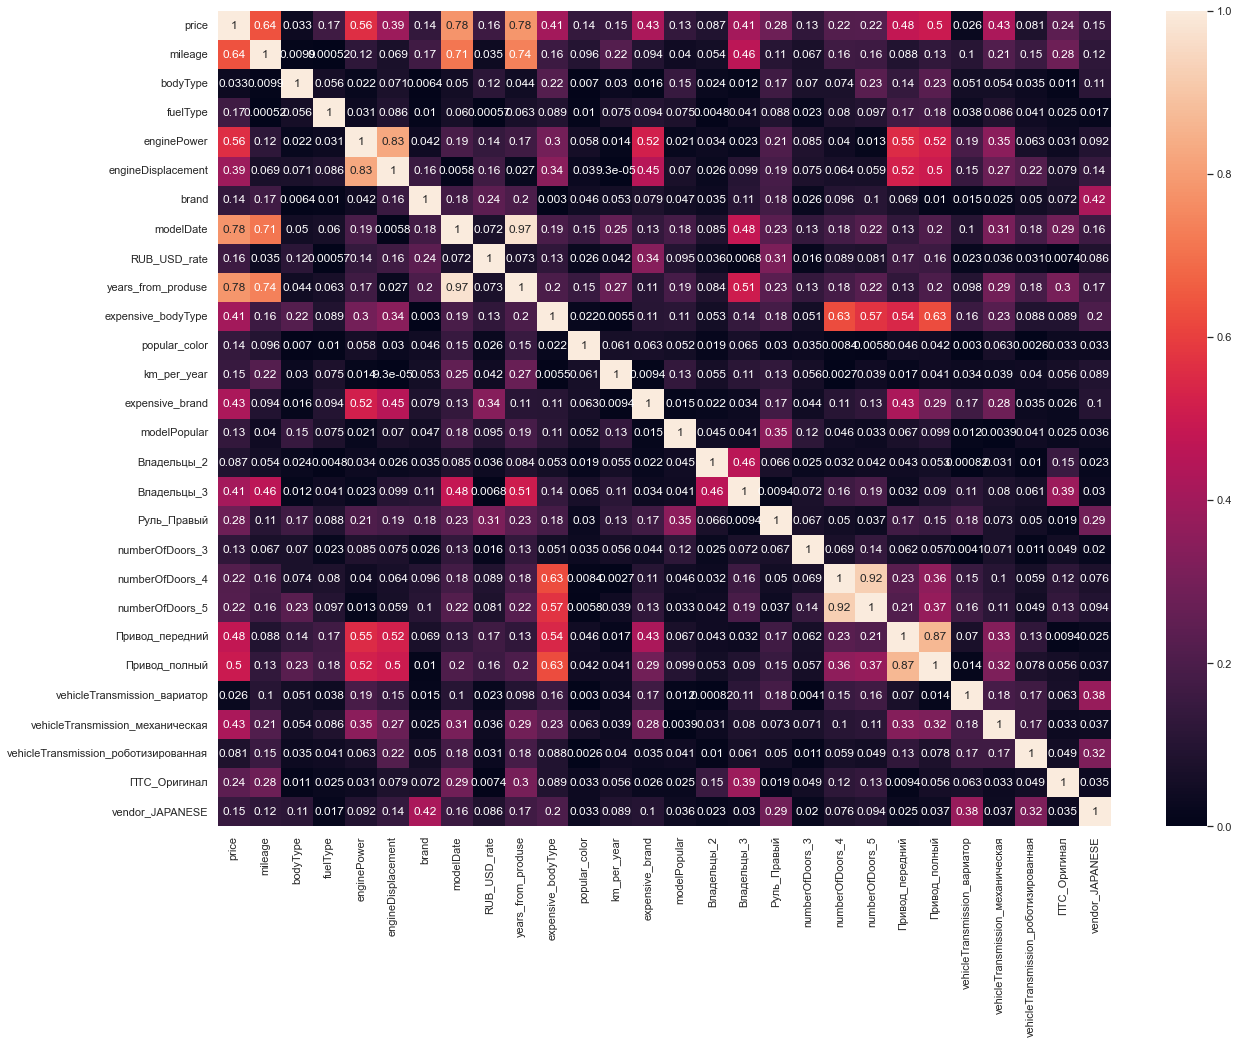

In [890]:
plt.figure(figsize=(20, 15))
sns.heatmap(data_train.corr().abs(), vmin=0, vmax=1, annot=True, fmt ='.2g')
plt.show()

Ничего не будет удалять, все корреляции в зоне допустимой

# Наивная модель

In [915]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
y_pred = X_val['mileage'].apply(lambda x: y_train.median())

#оцениваем точность 
print(mape(y_val, y_pred))

110.26809092793212


In [891]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [892]:
from copy import copy
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

In [893]:
# Напишем нашу метрику в виде функции
def mape(y_true, y_pred):
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

MAPE_scorer = make_scorer(score_func=mape, greater_is_better=False)

In [894]:
X_test=data_test.drop(columns=['sell_id'])

# Нахождение лучших параметров

In [238]:
# Начнём с простого -- обучим каждую модель в отдельности и найдём лучшие гиперпараметры
# Напишем функцию, которая на вход будет принимать модель и словарь гиперпараметров

def fit_best(model, param_grid):
    cv = RepeatedKFold(n_repeats=3)
    gs_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring=MAPE_scorer, cv=cv, n_jobs=-1)
    if type(model).__name__ == 'CatBoostRegressor':
        X_train_aux = copy(X_train_for_cat)
        X_val_aux = copy(X_val_for_cst)
        X_train_aux[cat_features] = X_train_aux[cat_features].astype(str).values
        X_val_aux[cat_features] = X_val_aux[cat_features].astype(str).values
    else:
        X_train_aux = X_train.values
        X_val_aux = X_val.values
    gs_model.fit(X_train_aux, y_train)
    print(f'Best {type(model).__name__} has cv MAPE of {-gs_model.best_score_}')
    print(f'Best {type(model).__name__} has {gs_model.best_params_}')
    print(f'Validation score is {mape(y_val, gs_model.best_estimator_.predict(X_val_aux))}')

In [506]:
fit_best(model=ElasticNet(max_iter=3000),
               param_grid={'alpha': np.logspace(1e-2, 1e2, 4),
                           'l1_ratio': np.linspace(0.1, 0.9, 4)
                          }
              )

Best ElasticNet has cv MAPE of 42.08841547460216
Best ElasticNet has {'alpha': 1.023292992280754, 'l1_ratio': 0.1}
Validation score is 41.8486916169352


In [510]:
fit_best(model=RandomForestRegressor(n_jobs=-1),
               param_grid={
                   'criterion': ['mse', 'mae'],
                   'n_estimators': [100, 250],
                   'min_samples_leaf': [10, 20]
                          }
              )

Best RandomForestRegressor has cv MAPE of 13.437401286832737
Best RandomForestRegressor has {'criterion': 'mse', 'min_samples_leaf': 10, 'n_estimators': 250}
Validation score is 13.053667159323748


In [511]:
fit_best(model=LGBMRegressor(),
               param_grid={
                   'n_estimators': [500, 1000],
                   'max_depth': [3, 5, 7],
                   'learning_rate': [0.01, 0.1, 1.],
               }
        )

Best LGBMRegressor has cv MAPE of 12.054165433026641
Best LGBMRegressor has {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}
Validation score is 12.1366890233637


In [512]:
fit_best(model=XGBRegressor(verbosity=0),
               param_grid={
                   'n_estimators': [500, 1000],
                   'max_depth': [3, 5, 7],
                   'learning_rate': [0.01, 0.1, 1.],
               }
        )

Best XGBRegressor has cv MAPE of 11.716513520550885
Best XGBRegressor has {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}
Validation score is 11.741543238767333


# XGBRegressor

In [519]:
cv = RepeatedKFold(n_repeats=3)

In [520]:
XGBR_model=XGBRegressor(learning_rate= 0.1, max_depth= 7, n_estimators= 1000)

In [521]:
XGBR_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [522]:
y_pred_xgb=XGBR_model.predict(X_val)

In [523]:
mape(y_val, y_pred_xgb)

11.800520392752883

In [622]:
XGBR_model.fit(X, Y)
y_pred_xgb_test=XGBR_model.predict(X_test)
data_test['price']=np.exp(y_pred_xgb_test)
submission_xgb=data_test[['sell_id', 'price']]
submission_xgb.to_csv('submission_xgb.csv', index=False)

# CatBoostRegressor

Лучшие параметры найдены коллегой для CatBoostRegressor

In [540]:
from catboost import CatBoostRegressor, Pool

In [556]:
X_train_for_cat['bodyType']=X_train_for_cat['bodyType'].astype(str)
X_train_for_cat['brand']=X_train_for_cat['brand'].astype(str)
X_train_for_cat['fuelType']=X_train_for_cat['fuelType'].astype(str)
X_train_for_cat['vehicleTransmission']=X_train_for_cat['vehicleTransmission'].astype(str)
X_train_for_cat['Привод']=X_train_for_cat['Привод'].astype(str)
X_train_for_cat['Руль']=X_train_for_cat['Руль'].astype(str)
X_train_for_cat['ПТС']=X_train_for_cat['ПТС'].astype(str)
X_train_for_cat['vendor']=X_train_for_cat['vendor'].astype(str)

In [560]:
X_val_for_cat['bodyType']=X_val_for_cat['bodyType'].astype(str)
X_val_for_cat['brand']=X_val_for_cat['brand'].astype(str)
X_val_for_cat['fuelType']=X_val_for_cat['fuelType'].astype(str)
X_val_for_cat['vehicleTransmission']=X_val_for_cat['vehicleTransmission'].astype(str)
X_val_for_cat['Привод']=X_val_for_cat['Привод'].astype(str)
X_val_for_cat['Руль']=X_val_for_cat['Руль'].astype(str)
X_val_for_cat['ПТС']=X_val_for_cat['ПТС'].astype(str)
X_val_for_cat['vendor']=X_val_for_cat['vendor'].astype(str)

In [557]:
cat_features = np.array([0, 2, 3, 4, 5, 7, 8, 11, 16, 20])

In [572]:
model = CatBoostRegressor(iterations = 6500, random_seed=42, learning_rate = 0.05, one_hot_max_size=0,
                               eval_metric='MAPE', custom_metric=['R2', 'MAE'], thread_count=-1, depth = 10,
                               l2_leaf_reg = 0.5, rsm=0.5)
pool = Pool(X_train_for_cat.values, label = np.log(y_train_for_cat), cat_features = cat_features)
pool_ev = Pool(X_val_for_cat.values, label = np.log(y_val_for_cat), cat_features = cat_features)

model.fit(pool, eval_set = pool_ev, verbose_eval=False, use_best_model=True,
         plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [573]:
predict = model.predict(X_val_for_cat.values)

In [574]:
mape(y_val, predict)

99.99784827082009

# LGBMRegressor

In [524]:
lgbm_model=LGBMRegressor(learning_rate = 0.1, max_depth = 7, n_estimators = 1000)

In [526]:
lgbm_model.fit(X_train.values, y_train)

LGBMRegressor(max_depth=7, n_estimators=1000)

In [527]:
y_pred_lgbm=lgbm_model.predict(X_val)

In [528]:
mape(y_val, y_pred_lgbm)

12.136677303473943

In [624]:
lgbm_model.fit(X.values, Y)
y_pred_lgbm_test=lgbm_model.predict(X_test)
data_test['price']=np.exp(y_pred_lgbm_test)
submission_lgbm=data_test[['sell_id', 'price']]
submission_lgbm.to_csv('submission_lgbm.csv', index=False)

# RandomForestRegressor

In [529]:
rf_model = RandomForestRegressor(criterion = 'mse', min_samples_leaf = 10, n_estimators = 250, n_jobs=-1, random_state=42)

In [530]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=10, n_estimators=250, n_jobs=-1,
                      random_state=42)

In [531]:
y_pred_rf=rf_model.predict(X_val)

In [532]:
mape(y_val, y_pred_rf)

13.080740153162473

In [625]:
rf_model.fit(X, Y)
y_pred_rf_test=rf_model.predict(X_test)
data_test['price']=np.exp(y_pred_rf_test)
submission_rf=data_test[['sell_id', 'price']]
submission_rf.to_csv('submission_rf.csv', index=False)

# LinearRegression

In [566]:
from sklearn.linear_model import LinearRegression

In [567]:
reg_model = LinearRegression(n_jobs=-1)

In [568]:
reg_model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [569]:
y_pred_reg=reg_model.predict(X_val)

In [570]:
mape(y_val, y_pred_reg)

21.997887108764548

# Staking

In [895]:
from tqdm import tqdm

In [896]:
from sklearn.base import clone

In [897]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the model.
    
    :arg model: model to compute features
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_model = clone(model)
        folded_model.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
    
    meta_model = clone(model)
    meta_model.fit(X_train, y_train)
    
    X_meta_test = meta_model.predict(X_test)
    
    return X_meta_train, X_meta_test

def generate_meta_features(models, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of models.
    
    :arg classifiers: list of models
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(model, X_train, X_test, y_train, cv)
        for model in tqdm(models)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [898]:
cv5 = KFold(n_splits=5, shuffle=True) 
cv3 = KFold(n_splits=3, shuffle=True) #для CatBoost

In [899]:
models = [XGBRegressor(learning_rate = 0.1, max_depth = 7, n_estimators = 1000), 
          LGBMRegressor(learning_rate = 0.1, max_depth = 7, n_estimators = 1000),
          RandomForestRegressor(criterion = 'mse', min_samples_leaf = 10, n_estimators = 250, n_jobs=-1)]

In [900]:
stacked_features_train, stacked_features_test = generate_meta_features(models, X_train.values, X_val.values, 
                                                                       y_train.values, cv5)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:44<00:00, 34.76s/it]


In [901]:
model_stack = LinearRegression(n_jobs=-1)

In [902]:
X_meta_train, X_meta_test = compute_meta_feature(model_stack, X_train.values, X_val.values, y_train.values, cv5)

In [903]:
stacked_features_train = np.hstack([stacked_features_train, X_meta_train.reshape(-1,1)])
stacked_features_test = np.hstack([stacked_features_test, X_meta_test.reshape(-1,1)])

In [904]:
rgs = LinearRegression(n_jobs=-1)
rgs.fit(stacked_features_train, y_train.values)
predict_stack = rgs.predict(stacked_features_test)

In [905]:
mape(y_val, predict_stack)

11.70174903969853

# AdaBoostRegressor

In [589]:
from sklearn.ensemble import AdaBoostRegressor

In [590]:
ab_model=AdaBoostRegressor(learning_rate = 0.1, random_state=42, n_estimators = 1000)

In [591]:
ab_model.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.1, n_estimators=1000, random_state=42)

In [592]:
y_pred_ab=ab_model.predict(X_val)

In [593]:
mape(y_val, y_pred_ab)

27.158710282242442

# GradientBoostingRegressor

In [594]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

  0%|                                                                                            | 0/3 [11:57<?, ?it/s]


In [596]:
gbr_model = GradientBoostingRegressor(criterion = 'mse', min_samples_leaf = 10, n_estimators = 250, random_state=42)

In [597]:
gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', min_samples_leaf=10,
                          n_estimators=250, random_state=42)

In [598]:
y_pred_gbr=gbr_model.predict(X_val)

In [599]:
mape(y_val, y_pred_gbr)

14.41528445987956

# ExtraTreesRegressor

In [600]:
from sklearn.ensemble import ExtraTreesRegressor

In [601]:
exr_model = ExtraTreesRegressor(criterion = 'mse', min_samples_leaf = 10, n_estimators = 250, random_state=42)

In [602]:
exr_model.fit(X_train, y_train)

ExtraTreesRegressor(min_samples_leaf=10, n_estimators=250, random_state=42)

In [603]:
y_pred_exr=exr_model.predict(X_val)

In [604]:
mape(y_val, y_pred_exr)

12.679743301801679

In [626]:
exr_model.fit(X, Y)
y_pred_exr_test=exr_model.predict(X_test)
data_test['price']=np.exp(y_pred_exr_test)
submission_exr=data_test[['sell_id', 'price']]
submission_exr.to_csv('submission_exr.csv', index=False)

# Staking для тестовых данных

In [907]:
stacked_features_train_test, stacked_features_test_test = generate_meta_features(models, X.values, X_test.values, 
                                                                       Y.values, cv5)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:06<00:00, 42.04s/it]


In [908]:
X_meta_train_test, X_meta_test_test = compute_meta_feature(model_stack, X.values, X_test.values, Y.values, cv5)

In [909]:
stacked_features_train_test = np.hstack([stacked_features_train_test, X_meta_train_test.reshape(-1,1)])
stacked_features_test_test = np.hstack([stacked_features_test_test, X_meta_test_test.reshape(-1,1)])

In [910]:
rgs_test = LinearRegression(n_jobs=-1)
rgs_test.fit(stacked_features_train_test, Y.values)
predict_stack_test = rgs_test.predict(stacked_features_test_test)

In [911]:
data_test['price']=np.exp(predict_stack_test)
submission_exr=data_test[['sell_id', 'price']]
submission_exr.to_csv('submission_stack.csv', index=False)